In [2]:
import librosa as lr
import numpy as np
import pandas as pd
import os

In [4]:
# Based on theory referred from various papers, we have found that below analysis 
# are most important for detecting speech features which could be relevant to
# detecting emotions. Tonal and pitch analysis are generally difficult to analyse as 
# they are very complex. We are using librosa library to extract below features which are
# basically categorized into spectral (related to spectrum of audio), prosodic (stress and 
# inotation patterns of speech) and qualitative (representing characteristic of voice). 
# Based on this understanding, and through experimentation, we hope to find relevant features 
# to emotions in speech. 

# Extraction of spectral features 
def spectral_features(y,sr,stft):
    # 1. MFCC (40 most important features)
    mfccs = lr.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mean_mfccs = np.mean(mfccs.T,axis=0) 
    # 2. Pitch Chroma
    p_chroma = lr.feature.chroma_stft(S=stft, sr=sr)
    mean_p_chroma = np.mean(p_chroma.T,axis=0)
    # 3. Spectral Centroid
    sp_centroid = lr.feature.spectral_centroid(y=y, sr=sr)
    mean_sp_centroid = np.mean(sp_centroid.T,axis=0)
    # 4. Spectral Skewness/Contrast
    contrast = lr.feature.spectral_contrast(S=stft, sr=sr)
    mean_contrast = np.mean(contrast.T,axis=0)
    
    return mean_mfccs,mean_p_chroma,mean_sp_centroid,mean_contrast

# Extraction of prosodic features
def prosodic_features(y):
    # 1. Zero crossing rate
    zcr = lr.feature.zero_crossing_rate(y)
    mean_zcr = np.mean(zcr.T,axis=0)
    # 2. Root mean square and energy
    rmse = lr.feature.rmse(y=y)
    mean_rmse = np.mean(rmse.T,axis=0)
    
    return mean_zcr,mean_rmse

def qualitative_features(y,sr):
    # 1. For tone analysis, we calculate mel frequencies
    mel = lr.feature.melspectrogram(y, sr=sr)
    mean_mel = np.mean(mel.T,axis=0)
    
    return mean_mel

In [13]:
# Function to parse data file name and return the gender and emotion of the speaker
def parse_filename(file):
    emotion_dict = {'01': 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}
    gender = 'female' if int(file[18]+file[19])%2 == 0 else 'male'
    return gender,emotion_dict[file[6]+file[7]]

def create_data_ravdess(data_dir_ravdess):
    
    data = []
    
    list_dir = os.listdir(data_dir_ravdess)
    
    emotion = {'happy':0,'sad':1,'fearful':2,'angry':3}
    
    for each in list_dir:
        
        file = data_dir_ravdess+'/'+each
        
        if file.endswith(".wav"):
            #print(file)

            gender,emo = parse_filename(each)
                
            
            if emo in ['happy','sad','fearful','angry']:
                

                # Loading data file to librosa and calculate y and sample rate
                y, sr = lr.load(file)
                # Generate short term Fourier Transform (stft)
                stft = np.abs(lr.stft(y)) 

                f_mfccs,f_p_chroma,f_sp_centroid,f_contrast = spectral_features(y,sr,stft)
                f_zcr,f_rmse = prosodic_features(y)
                f_mel = qualitative_features(y,sr)

                row = np.concatenate((f_mfccs,f_p_chroma,f_sp_centroid,f_contrast,f_zcr,f_rmse,f_mel,[emotion[emo]]))

                data.append(row)

    return pd.DataFrame(data)

In [19]:
def create_data_cremad(data_dir_cremad):
    
    emotion =  {'HAP':0,'SAD':1,'ANG':3,'FEA':2}
    
    data = []
    
    list_dir = os.listdir(data_dir_cremad)
    
    for file in list_dir:

        emo = file.split('_')[2]
        if emo in ['HAP','SAD','FEA','ANG']:
            if file.endswith(".wav"):
     
                # Loading data file to librosa and calculate y and sample rate
                y, sr = lr.load(data_dir_cremad+'/'+file)
                # Generate short term Fourier Transform (stft)
                stft = np.abs(lr.stft(y)) 

                f_mfccs,f_p_chroma,f_sp_centroid,f_contrast = spectral_features(y,sr,stft)
                f_zcr,f_rmse = prosodic_features(y)
                f_mel = qualitative_features(y,sr)

                row = np.concatenate((f_mfccs,f_p_chroma,f_sp_centroid,f_contrast,f_zcr,f_rmse,f_mel,[emotion[emo]]))

                data.append(row)

    return pd.DataFrame(data)

In [20]:
def create_data_others(data_dir):
    
    data = []
    
    for i in [0,1,2,3]:
        path = data_dir+'/'+str(i)+'/'
        list_dir =  os.listdir(path)

        for file in list_dir:

            if file.endswith(".wav"):
                #print(file)

                # Loading data file to librosa and calculate y and sample rate
                y, sr = lr.load(path+file)
                # Generate short term Fourier Transform (stft)
                stft = np.abs(lr.stft(y)) 

                f_mfccs,f_p_chroma,f_sp_centroid,f_contrast = spectral_features(y,sr,stft)
                f_zcr,f_rmse = prosodic_features(y)
                f_mel = qualitative_features(y,sr)

                row = np.concatenate((f_mfccs,f_p_chroma,f_sp_centroid,f_contrast,f_zcr,f_rmse,f_mel,[i]))

                data.append(row)

    return pd.DataFrame(data)
   

In [23]:
# Get the data directory which stores the audio files
data_dir_ravdess = 'training_data/ravdess'
data_dir_tess = 'training_data/tess'
data_dir_savee = 'training_data/savee'
data_dir_cremad = 'training_data/crema_d'
data_dir_bdes = 'training_data/bdes'


# Create data for all the data directories
data_ravdess = create_data_ravdess(data_dir_ravdess)
data_cremad = create_data_cremad(data_dir_cremad)
data_tess = create_data_others(data_dir_tess)
data_savee = create_data_others(data_dir_savee)
data_bdes = create_data_others(data_dir_bdes)


C:\Users\utkar\Anaconda3\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [24]:
# Concatenate all data into a single Dataframe
data = pd.concat([data_ravdess, data_cremad, data_tess, data_savee, data_bdes])
data.shape

(8021, 191)

In [37]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,-646.130257,63.436045,-4.705014,12.907815,3.926321,-2.585449,-5.982906,-6.311690,-11.837655,-2.075405,...,0.000010,0.000006,0.000011,0.000007,0.000010,0.000011,0.000006,0.000004,3.296748e-07,0.0
1,-584.981918,43.497349,-21.613513,8.840687,-7.184710,-5.850826,-4.939766,-12.593667,-4.777969,-3.069792,...,0.000048,0.000044,0.000041,0.000036,0.000023,0.000032,0.000031,0.000008,7.735573e-07,0.0
2,-541.433974,62.939903,-10.896681,5.023488,2.941020,-0.349534,-14.487152,-10.850216,-9.839632,-8.713090,...,0.000203,0.000155,0.000147,0.000153,0.000108,0.000153,0.000139,0.000068,5.344014e-06,0.0
3,-650.659798,46.812761,-16.539898,6.699998,-8.078243,-8.253147,-8.076603,-13.949132,-8.494425,-4.106237,...,0.000024,0.000031,0.000033,0.000022,0.000023,0.000016,0.000007,0.000003,2.376553e-07,0.0
4,-676.171373,65.932610,4.009063,15.863403,8.687657,2.067518,-0.919425,-0.706527,-10.634650,-2.900578,...,0.000006,0.000007,0.000009,0.000008,0.000007,0.000007,0.000005,0.000001,7.006203e-08,0.0


In [33]:
# Save data into a file
data.to_csv('training_data/data.csv')

In [34]:
# Get the correlation between the columns 

corr_matrix_train = data.corr().abs()

In [36]:
import numpy as np

## This code is based on Chris Albon's code to drop the correlated columns from a data frame
upper = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(np.bool))
to_drop = [int(column) for column in upper.columns if any(upper[column] > 0.95)]
print("Columns with high correlation to be removed:")
print(to_drop)

Columns with high correlation to be removed:
[169, 179, 180, 181, 182, 183, 187, 188, 189]


In [38]:
# Remove the columns from data frame and create another data frame as df

df = data.drop(data.columns[to_drop], axis=1)

In [39]:
df.columns = range(df.shape[1])

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,-646.130257,63.436045,-4.705014,12.907815,3.926321,-2.585449,-5.982906,-6.311690,-11.837655,-2.075405,...,0.000017,0.000023,0.000013,0.000012,0.000009,0.000020,0.000007,0.000010,0.000011,0.0
1,-584.981918,43.497349,-21.613513,8.840687,-7.184710,-5.850826,-4.939766,-12.593667,-4.777969,-3.069792,...,0.000026,0.000022,0.000033,0.000047,0.000055,0.000065,0.000036,0.000023,0.000032,0.0
2,-541.433974,62.939903,-10.896681,5.023488,2.941020,-0.349534,-14.487152,-10.850216,-9.839632,-8.713090,...,0.001259,0.001030,0.000504,0.000401,0.000554,0.000345,0.000153,0.000108,0.000153,0.0
3,-650.659798,46.812761,-16.539898,6.699998,-8.078243,-8.253147,-8.076603,-13.949132,-8.494425,-4.106237,...,0.000019,0.000061,0.000083,0.000091,0.000075,0.000117,0.000022,0.000023,0.000016,0.0
4,-676.171373,65.932610,4.009063,15.863403,8.687657,2.067518,-0.919425,-0.706527,-10.634650,-2.900578,...,0.000038,0.000046,0.000031,0.000008,0.000006,0.000006,0.000008,0.000007,0.000007,0.0


In [41]:
df.shape

(8021, 182)

In [52]:
#Feature selection using Backward Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

X = df[df.columns[0:181]]
Y = df[181]

# feature extraction
model = LogisticRegression() #SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1) #

rfe = RFE(model, 100)
fit = rfe.fit(X, Y)
print("Num Features: ",fit.n_features_)
print("Selected Features: ",fit.support_)
print("Feature Ranking: ",fit.ranking_)

Num Features:  100
Selected Features:  [False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True False False  True  True  True  True  True False
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False  True  True False  True False  True  True  True False  True
  True False  True  True  True  True False False  True False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True

In [104]:
print(X.columns[fit.support_])

Int64Index([ 11,  28,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
             51,  54,  55,  56,  57,  58,  60,  61,  62,  63,  64,  93,  96,
             98,  99, 101, 103, 104, 105, 107, 108, 110, 111, 112, 113, 116,
            120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
            133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
            146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
            159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
            172, 173, 174, 175, 176, 177, 178, 179, 180],
           dtype='int64')


In [55]:
X = df[df.columns[0:181]]
y = df[181]
df[X.columns[fit.support_]].head()

,11,28,40,41,42,43,44,45,46,47,...,171,172,173,174,175,176,177,178,179,180
0,-6.506576,-4.230472,0.763436,0.790995,0.763995,0.774775,0.759068,0.709952,0.672845,0.702815,...,0.000016,0.000017,0.000023,0.000013,0.000012,0.000009,0.000020,0.000007,0.000010,0.000011
1,-2.429099,2.132234,0.705350,0.653129,0.632511,0.629488,0.613461,0.670480,0.763453,0.745118,...,0.000049,0.000026,0.000022,0.000033,0.000047,0.000055,0.000065,0.000036,0.000023,0.000032
2,-7.089989,-2.473618,0.594999,0.580023,0.641304,0.752040,0.728397,0.653160,0.659680,0.655550,...,0.000774,0.001259,0.001030,0.000504,0.000401,0.000554,0.000345,0.000153,0.000108,0.000153
3,-8.504312,-2.049245,0.458457,0.471476,0.456127,0.464032,0.457922,0.464545,0.475808,0.516776,...,0.000024,0.000019,0.000061,0.000083,0.000091,0.000075,0.000117,0.000022,0.000023,0.000016
4,-2.081819,-1.316368,0.671510,0.717728,0.744103,0.731981,0.739587,0.718110,0.722261,0.694046,...,0.000053,0.000038,0.000046,0.000031,0.000008,0.000006,0.000006,0.000008,0.000007,0.000007


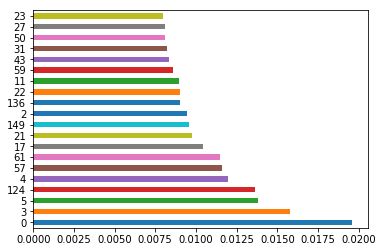

In [100]:
# Plotting the most important features for data

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

imp_features = pd.Series(model.feature_importances_, index=X.columns)
imp_features.nlargest(20).plot(kind='barh')
plt.show()


In [60]:
# Scale and normalise the data for testing 

from sklearn import preprocessing

X_normal = preprocessing.normalize(X, norm='l2') #preprocessing.scale(X_data)
X_scaled = preprocessing.scale(X)


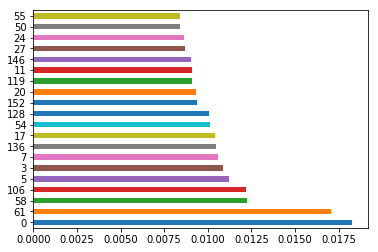

In [101]:
# Plotting the most important features for scaled data

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_scaled,y)

imp_features = pd.Series(model.feature_importances_, index=X.columns)
imp_features.nlargest(20).plot(kind='barh')
plt.show()

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [110]:
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss

svclassifier = SVC(degree=6)  

svclassifier.fit(X_train_scaled, y_train)  

predicted = svclassifier.predict(X_test_scaled)

score = accuracy_score(predicted, y_test)

print(score)

0.23302180685358256


In [91]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

predicted=clf.predict(X_test)

score = accuracy_score(predicted, y_test)

print(score)

0.7133956386292835


In [92]:
# Create base model using Gaussian Naive Bayes 
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

model_nb.fit(X_train,y_train)

predicted= model_nb.predict(X_test)

score = accuracy_score(predicted, y_test)

print(score)

0.42679127725856697


In [93]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
onehotencoder = OneHotEncoder()

X_train =np.expand_dims(X_train, axis=2)
X_test= np.expand_dims(X_test, axis=2)

y_train = onehotencoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = onehotencoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten,Activation, Dropout,MaxPooling1D
import keras

#create model
model = Sequential()
#add model layers

model.add(Conv1D(200, 5, activation='relu', padding='same', input_shape=(181,1)))
model.add(Conv1D(100, 5, activation='relu', padding='same'))
model.add(Dropout(0.1))

model.add(Conv1D(100, 5, activation='relu', padding='same'))

model.add(Conv1D(100, 5, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

#compile model using accuracy to measure model performance
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model.fit(X_train, y_train, batch_size=8, epochs=20, validation_data=(X_test, y_test))

Train on 6416 samples, validate on 1605 samples
Epoch 1/20
6416/6416 [==============================] - 31s 5ms/step - loss: 1.7031 - acc: 0.3932 - val_loss: 1.0992 - val_acc: 0.5396
Epoch 2/20
6416/6416 [==============================] - 31s 5ms/step - loss: 1.0132 - acc: 0.5729 - val_loss: 0.9113 - val_acc: 0.6224
Epoch 3/20
6416/6416 [==============================] - 32s 5ms/step - loss: 0.9005 - acc: 0.6166 - val_loss: 0.8437 - val_acc: 0.6486
Epoch 4/20
6416/6416 [==============================] - 32s 5ms/step - loss: 0.8439 - acc: 0.6392 - val_loss: 0.8146 - val_acc: 0.6498
Epoch 5/20
6416/6416 [==============================] - 33s 5ms/step - loss: 0.8092 - acc: 0.6555 - val_loss: 0.8302 - val_acc: 0.6492
Epoch 6/20
6416/6416 [==============================] - 32s 5ms/step - loss: 0.7838 - acc: 0.6682 - val_loss: 0.7770 - val_acc: 0.6822
Epoch 7/20
6416/6416 [==============================] - 36s 6ms/step - loss: 0.7540 - acc: 0.6789 - val_loss: 0.7701 - val_acc: 0.6760
Epoch 8

In [106]:
model_name = 'Model_Emotion_Speech.h5'
save_dir = 'saved_models'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

import json
model_json = model.to_json()
with open(save_dir+"/model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at saved_models\Model_Emotion_Speech.h5 
